# Functional Data Cleaning with Pandas

Questions to answer:
- why is data processing wrangling important?
- what's good about pandas? 
- what is this article aiming to achieve?

## Import Libraries

In [130]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

## Load data

In [131]:
path = Path().cwd().parent / 'data' / 'player_info.parquet'
data = pd.read_parquet(path)

In [132]:
df = data.copy()

## Check data

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dob           856 non-null    object
 1   age           856 non-null    int64 
 2   country       856 non-null    object
 3   current_club  854 non-null    object
 4   height        856 non-null    object
 5   name          856 non-null    object
 6   position      856 non-null    object
 7   value         856 non-null    object
 8   joined_date   687 non-null    object
 9   number        856 non-null    object
 10  signed_from   687 non-null    object
 11  signing_fee   856 non-null    object
 12  tm_id         856 non-null    object
 13  tm_name       856 non-null    object
 14  foot          856 non-null    object
 15  season        856 non-null    int64 
 16  team          856 non-null    object
dtypes: int64(2), object(15)
memory usage: 113.8+ KB


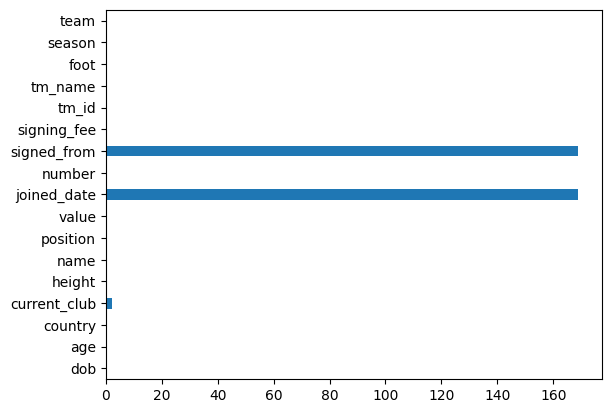

In [134]:
df.isnull().sum().plot(kind='barh')
plt.show()

# Data Processing

## Dealing with Dates

In [135]:
# df[['dob_month', 'dob_day', 'dob_year']] = df['dob'].str.replace(',', '').str.split(' ', expand=True)

In [136]:
# df = df.drop(columns=['dob'])

In [137]:
# def expand_date(df: pd.DataFrame, column: str) -> pd.DataFrame:
#     data = df.copy()
#     columns = [f'{column}_month', f'{column}_day', f'{column}_year']
#     data[columns] = data[column].str.replace(',', '').str.split(' ', expand=True)
#     return data.drop(columns=[column])

In [138]:
def convert_dts(df: pd.DataFrame, column: str) -> pd.DataFrame:
    data = df.copy()
    data.loc[:, column] = pd.to_datetime(data[column], errors='coerce')
    return data

#### Height column

- regex
- converting to numeric

Regex can be used on a pandas column to replace a value.

In [139]:
df.loc[:, "height"] = df["height"].str.replace(
    r"[,m]", "", regex=True
)  # remove commas and meters
df.loc[:, "height"] = (
    pd.to_numeric(df["height"], errors="coerce").round().astype("Int64")
)  # convert to numeric

In [140]:
def process_height(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()  # make a copy of the dataframe
    data.loc[:, "height"] = data["height"].str.replace(
        r"[,m]", "", regex=True
    )  # remove commas and meters
    data.loc[:, "height"] = (
        pd.to_numeric(data["height"], errors="coerce").round().astype("Int64")
    )  # convert to numeric
    return data

#### Value Column

- match-case
- apply

In [141]:
df['value'].str.replace(r'[\€m]', '', regex=True)

0      35.00
1       9.00
2       2.00
3       500k
4       200k
       ...  
851     4.00
852     1.00
853     350k
854     275k
855        0
Name: value, Length: 856, dtype: object

Dealing with the value column requires extra care as there are two different ways of recording values - millions and thousands. If we simply remove € and m or k, then the values with k will have a much larger value than the ones with m - which is obviously wrong. We have to scale the k values to millions e.g. 400k -> 0.4

To do this, we can combine match-case syntax to implement some logic and then use the .apply() to apply the match-case as a function to the column.

Match-case is fairly new and requires Python 3.10 and is a good alternative to if-else.

In [142]:
values = df['value'].tolist()

for value in values:
    match value:
        case value if 'k' in value:
            value = float(re.sub(r'[\€k]', '', value)) / 1000
            print(value)
        case value if 'm' in value:
            value = float(re.sub(r'[\€m]', '', value))
            print(value)
        case _:
            value = float(re.sub(r'[\€]', '', value))
            print(value)

35.0
9.0
2.0
0.5
0.2
80.0
45.0
40.0
38.0
22.0
20.0
0.5
75.0
10.0
4.0
38.0
13.0
10.0
120.0
25.0
9.0
1.5
0.8
50.0
30.0
12.0
80.0
70.0
50.0
65.0
60.0
2.0
150.0
25.0
180.0
90.0
35.0
25.0
7.0
2.0
1.8
80.0
70.0
38.0
5.0
0.3
38.0
30.0
12.0
2.0
55.0
35.0
4.0
2.0
0.25
120.0
18.0
12.0
3.5
2.0
0.4
15.0
0.2
110.0
70.0
22.0
22.0
8.0
70.0
35.0
0.6
140.0
15.0
2.0
65.0
30.0
20.0
20.0
1.0
0.7
0.3
0.25
0.15
0.1
50.0
40.0
30.0
25.0
13.0
5.0
4.8
4.0
1.0
0.5
0.25
0.25
40.0
28.0
25.0
0.5
0.25
0.2
40.0
35.0
0.3
75.0
35.0
25.0
0.3
75.0
50.0
15.0
15.0
10.0
1.2
0.3
0.2
0.0
80.0
65.0
0.9
35.0
35.0
3.0
0.0
28.0
35.0
22.0
12.0
9.0
1.8
0.2
28.0
20.0
5.0
0.6
0.3
0.2
45.0
30.0
28.0
22.0
8.0
3.5
1.8
1.5
0.2
30.0
22.0
1.25
0.7
70.0
15.0
4.0
13.0
11.0
75.0
75.0
35.0
35.0
35.0
10.0
1.0
0.5
0.3
14.0
0.5
75.0
50.0
50.0
1.0
0.3
55.0
10.0
1.2
70.0
1.0
35.0
1.2
1.2
0.6
0.5
60.0
55.0
25.0
17.0
12.0
8.0
2.2
1.8
0.5
45.0
12.0
10.0
45.0
18.0
35.0
18.0
15.0
45.0
35.0
0.0
10.0
70.0
16.0
45.0
14.0
13.0
2.0
0.2
0.0
55.0
48.0
1.5
38.0

In [143]:
def convert_value(value: str) -> float:
    match value:
        case value if 'k' in value:
            return float(re.sub(r'[\€k]', '', value)) / 1000
        case value if 'm' in value:
            return float(re.sub(r'[\€m]', '', value))
        case _:
            return float(re.sub(r'[\€]', '', value))

In [144]:
df['value'].apply(convert_value)

0      35.000
1       9.000
2       2.000
3       0.500
4       0.200
        ...  
851     4.000
852     1.000
853     0.350
854     0.275
855     0.000
Name: value, Length: 856, dtype: float64

#### Signing Fee Column

Extending match-case and apply

In [145]:
def convert_value(value: str) -> float:
    match value.lower():
        case value if 'k' in value:
            return float(re.sub(r'[\€k]', '', value)) / 1000
        case value if 'm' in value:
            return float(re.sub(r'[\€m]', '', value))
        case 'free transfer' | '?' | '-':
            return 0.0
        case _:
            return float(re.sub(r'[\€]', '', value))

In [146]:
df['signing_fee'].apply(convert_value)

0      40.00
1       0.00
2       6.82
3       0.00
4       0.00
       ...  
851     2.90
852     0.00
853     0.45
854     0.00
855     0.00
Name: signing_fee, Length: 856, dtype: float64

In [147]:
def clean_value(df: pd.DataFrame, column: str) -> pd.DataFrame:
    data = df.copy()
    data.loc[:, column] = data[column].apply(convert_value)
    return data

#### Number Column
- simple replace

In [148]:
df['number'].replace('-', 'No Number')

0             31
1             18
2             13
3      No Number
4             33
         ...    
851           19
852           10
853    No Number
854    No Number
855    No Number
Name: number, Length: 856, dtype: object

In [149]:
def clean_number(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.loc[:, 'number'] = data['number'].replace('-', 0)
    # data.loc[:, 'number'] = pd.to_numeric(data['number'], errors='coerce').astype('Int64')
    return data

Position Column

- Use pandas indexing to change a value

In [150]:
df['position'].value_counts()

position
Centre-Back           152
Central Midfield      121
Goalkeeper            103
Centre-Forward         92
Left Winger            69
Left-Back              68
Defensive Midfield     65
Right-Back             64
Attacking Midfield     59
Right Winger           53
Left Midfield           4
Right Midfield          3
Second Striker          2
Midfielder              1
Name: count, dtype: int64

In [151]:
# df.loc[df['position'] == 'Midfielder', 'position'] = 'Central Midfield'

In [152]:
def clean_position(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.loc[data['position'] == 'Midfielder', 'position'] = 'Central Midfield'
    return data

Current Club Column 

- simple replace

In [153]:
df['current_club'].value_counts()

current_club
Without ClubWithout Club    50
Chelsea FC                  38
Brighton & Hove Albion      35
Newcastle United            32
Aston Villa                 31
                            ..
Cambridge United             1
Ajax Amsterdam               1
Al-Ittihad Club              1
Shrewsbury Town              1
Dagenham & Redbridge FC      1
Name: count, Length: 142, dtype: int64

In [154]:
df['current_club'].replace('Without ClubWithout Club', 'No Club')

0          Manchester City
1          Manchester City
2          Colorado Rapids
3      Manchester City U21
4          Manchester City
              ...         
851             Luton Town
852             Luton Town
853             Luton Town
854                No Club
855         Luton Town U21
Name: current_club, Length: 856, dtype: object

In [155]:
def clean_current_club(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.loc[:, 'current_club'] = data['current_club'].replace('Without ClubWithout Club', 'No Club')
    return data

## Imputation

Foot column - stratified

In [156]:
df['foot'].unique()

array(['left', 'right', '\xa0', 'both'], dtype=object)

In [157]:
df['foot'].value_counts(normalize=True)

foot
right    0.650701
left     0.248832
         0.078271
both     0.022196
Name: proportion, dtype: float64

In [158]:
valid_vals = df['foot'][~df['foot'].isin(['\xa0', ''])] # remove empty strings
mask = df['foot'].isin(['\xa0', ''])

dist = valid_vals.value_counts(normalize=True)
impute_val = np.random.choice(dist.index, p=dist.values)

impute_val = np.random.choice(dist.index, p=dist.values, size=mask.sum())
df.loc[mask, 'foot'] = impute_val

In [159]:
def impute_foot(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    valid_vals = data['foot'][~df['foot'].isin(['\xa0', ''])] # remove empty strings
    mask = data['foot'].isin(['\xa0', ''])

    dist = valid_vals.value_counts(normalize=True)
    impute_val = np.random.choice(dist.index, p=dist.values, size=mask.sum())

    data.loc[mask, 'foot'] = impute_val
    return data

#### Height column - groupby

In [160]:
df['height'].isna().sum()

np.int64(81)

There are 81 players without a height. As heights vary based on position we can groupby position and get the median height which will likely be a more accurate imputation of height that taking the median value for all players

In [161]:
median_heights = df.groupby('position')['height'].transform('median')
df['height'] = df['height'].fillna(median_heights)

In [162]:
def impute_height(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    median_heights = data.groupby('position')['height'].transform('median')
    data.loc[:, 'height'] = data['height'].fillna(median_heights).round().astype('Int64')
    return data

#### All other imputations - impute with Unknown

In [163]:
def impute_with_unknown(df: pd.DataFrame, column: str) -> pd.DataFrame:
    data = df.copy()
    data.loc[:, column] = data[column].fillna('Unknown')
    return data

## Rename Columns

In [164]:
rename = {
    'value': 'value_euro_m',
    'signing_fee': 'signing_fee_euro_m',
}
df.rename(columns=rename)

,dob,age,country,current_club,height,name,position,value_euro_m,joined_date,number,signed_from,signing_fee_euro_m,tm_id,tm_name,foot,season,team
0,"Aug 17, 1993",30,Brazil,Manchester City,188.0,Ederson,Goalkeeper,€35.00m,"Jul 1, 2017",31,SL Benfica,€40.00m,238223,ederson,left,2023,manchester-city
1,"Nov 6, 1992",31,Germany,Manchester City,185.0,Stefan Ortega,Goalkeeper,€9.00m,"Jul 1, 2022",18,Arminia Bielefeld,free transfer,85941,stefan-ortega,right,2023,manchester-city
2,"Apr 2, 1995",29,United States,Colorado Rapids,191.0,Zack Steffen,Goalkeeper,€2.00m,"Jul 9, 2019",13,Columbus Crew SC,€6.82m,221624,zack-steffen,right,2023,manchester-city
3,"Nov 2, 2005",18,England,Manchester City U21,191.0,True Grant,Goalkeeper,€500k,None,-,None,0,919438,true-grant,left,2023,manchester-city
4,"Sep 3, 1985",38,England,Manchester City,188.0,Scott Carson,Goalkeeper,€200k,"Jul 20, 2021",33,Derby County,free transfer,14555,scott-carson,right,2023,manchester-city
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,"Apr 10, 1998",26,Scotland,Luton Town,178.0,Jacob Brown,Centre-Forward,€4.00m,"Aug 10, 2023",19,Stoke City,€2.90m,469958,jacob-brown,right,2023,luton-town
852,"Dec 2, 1994",29,England,Luton Town,184.0,Cauley Woodrow,Centre-Forward,€1.00m,"Jul 1, 2022",10,Barnsley FC,?,169801,cauley-woodrow,right,2023,luton-town
853,"Nov 18, 2002",21,Wales,Luton Town,185.0,Joe Taylor,Centre-Forward,€350k,"Jan 31, 2023",-,Peterborough United,€450k,944551,joe-taylor,right,2023,luton-town
854,"Aug 21, 1998",25,Zimbabwe,Without ClubWithout Club,183.0,Admiral Muskwe,Centre-Forward,€275k,"Jul 15, 2021",-,Leicester City U21,?,314378,admiral-muskwe,right,2023,luton-town


In [165]:
def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    rename = {
        'value': 'value_euro_m',
        'signing_fee': 'signing_fee_euro_m',
    }
    return df.rename(columns=rename)

## Handle data types

In [166]:
from pandas.api.types import is_numeric_dtype

def handle_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    dtypes = {
        "value_euro_m": "float64",
        "signing_fee_euro_m": "float64",
        "age": "Int16",
        "height": "Int16",
        "number": "Int16",  # Using Int64 to handle potential NaN values
        "country": "category",
        "foot": "category",
        "position": "category",
        'signed_from': 'category',
        'joined_date': 'datetime64[ns]',
        'dob': 'datetime64[ns]',
        'name': 'object',
        'current_club': 'category',
        "tm_id": "Int64",  # Using Int64 to handle potential NaN values
        "tm_name": "object",
        "team": "category",
        "season": "Int16",
    }

    for col, dtype in dtypes.items():
        if col in df.columns:
            match dtype:
                case "category":
                    df[col] = df[col].astype(dtype)
                case "float64" | "Int64" | "Int16":
                    if not is_numeric_dtype(df[col]):
                        df[col] = pd.to_numeric(df[col], errors="coerce").round().astype(dtype)
                case "datetime64[ns]":
                    df[col] = pd.to_datetime(df[col], errors="coerce")
                case _:
                    df[col] = df[col].astype(dtype)
        else:
            print(f"Warning: Column '{col}' not found in DataFrame")

    return df

## Pandas Pipeline

In [167]:
dff = (
    data
    .pipe(process_height)
    .pipe(clean_value, column="value")
    .pipe(clean_value, column="signing_fee")
    .pipe(clean_number)
    .pipe(clean_current_club)
    .pipe(clean_position)
    .pipe(impute_foot)
    .pipe(impute_height)
    .pipe(impute_with_unknown, column="current_club")
    .pipe(impute_with_unknown, column='signed_from')
    .pipe(rename_columns)
    .pipe(handle_dtypes)
)

In [168]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dob           856 non-null    object
 1   age           856 non-null    int64 
 2   country       856 non-null    object
 3   current_club  854 non-null    object
 4   height        856 non-null    object
 5   name          856 non-null    object
 6   position      856 non-null    object
 7   value         856 non-null    object
 8   joined_date   687 non-null    object
 9   number        856 non-null    object
 10  signed_from   687 non-null    object
 11  signing_fee   856 non-null    object
 12  tm_id         856 non-null    object
 13  tm_name       856 non-null    object
 14  foot          856 non-null    object
 15  season        856 non-null    int64 
 16  team          856 non-null    object
dtypes: int64(2), object(15)
memory usage: 113.8+ KB


In [169]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   dob                 856 non-null    datetime64[ns]
 1   age                 856 non-null    int64         
 2   country             856 non-null    category      
 3   current_club        856 non-null    category      
 4   height              856 non-null    Int16         
 5   name                856 non-null    object        
 6   position            856 non-null    category      
 7   value_euro_m        856 non-null    float64       
 8   joined_date         687 non-null    datetime64[ns]
 9   number              856 non-null    Int16         
 10  signed_from         856 non-null    category      
 11  signing_fee_euro_m  856 non-null    float64       
 12  tm_id               856 non-null    Int64         
 13  tm_name             856 non-null    object        

In [170]:
dff

,dob,age,country,current_club,height,name,position,value_euro_m,joined_date,number,signed_from,signing_fee_euro_m,tm_id,tm_name,foot,season,team
0,1993-08-17,30,Brazil,Manchester City,188,Ederson,Goalkeeper,35.0,2017-07-01,31,SL Benfica,40.0,238223,ederson,left,2023,manchester-city
1,1992-11-06,31,Germany,Manchester City,185,Stefan Ortega,Goalkeeper,9.0,2022-07-01,18,Arminia Bielefeld,0.0,85941,stefan-ortega,right,2023,manchester-city
2,1995-04-02,29,United States,Colorado Rapids,191,Zack Steffen,Goalkeeper,2.0,2019-07-09,13,Columbus Crew SC,7.0,221624,zack-steffen,right,2023,manchester-city
3,2005-11-02,18,England,Manchester City U21,191,True Grant,Goalkeeper,0.0,NaT,0,Unknown,0.0,919438,true-grant,right,2023,manchester-city
4,1985-09-03,38,England,Manchester City,188,Scott Carson,Goalkeeper,0.0,2021-07-20,33,Derby County,0.0,14555,scott-carson,right,2023,manchester-city
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,1998-04-10,26,Scotland,Luton Town,178,Jacob Brown,Centre-Forward,4.0,2023-08-10,19,Stoke City,3.0,469958,jacob-brown,right,2023,luton-town
852,1994-12-02,29,England,Luton Town,184,Cauley Woodrow,Centre-Forward,1.0,2022-07-01,10,Barnsley FC,0.0,169801,cauley-woodrow,right,2023,luton-town
853,2002-11-18,21,Wales,Luton Town,185,Joe Taylor,Centre-Forward,0.0,2023-01-31,0,Peterborough United,0.0,944551,joe-taylor,right,2023,luton-town
854,1998-08-21,25,Zimbabwe,No Club,183,Admiral Muskwe,Centre-Forward,0.0,2021-07-15,0,Leicester City U21,0.0,314378,admiral-muskwe,right,2023,luton-town
